In [2]:
# Imports
import pandas as pd
%matplotlib inline
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import random
import re
import operator
import numpy as np


#Data bron: https://www.kaggle.com/datasnaek/youtube-new/data

In [4]:
# Zet alle data van een csv bestand, naar een DataFrame.
trending_US = pd.DataFrame.from_csv('USvideos_1.csv')
trending_UK = pd.DataFrame.from_csv("GBvideos.csv")
trending_CA = pd.DataFrame.from_csv("CAvideos.csv")

# Verander de categorie ID's in categorietitels.
categories = pd.DataFrame.from_csv("categories.csv",index_col=None)
trending_US= trending_US.merge(categories,on="category_id")
trending_UK = trending_UK.merge(categories,on="category_id")
trending_CA = trending_CA.merge(categories,on="category_id")

In [6]:
# Voeg like en dislike ratios toe
trending_UK['like_view_ratio'] = trending_UK.likes / trending_UK.views
trending_UK['dislike_view_ratio'] = trending_UK.dislikes / trending_UK.views
trending_UK["like_dislike_ratio"] = trending_UK.likes / trending_UK.dislikes

In [10]:
# regelt timecodes
# we moeten tijden indelen in blokken van een uur dus 23:30 gaat in het blok van 00:00 en 04:45 in 05:00
times = [[int(y[0]),int(y[1])] for y in [x.split("T")[1][:-8].split(":") for x in trending_UK.publish_time]]
timecodes = [] 
for hour, minutes in times:
    if minutes==0:
        timecodes.append(hour)
    else:
        if hour != 23:
            timecodes.append(hour+1)
        else:
            timecodes.append(0)
trending_UK["timecode"]= pd.Series(timecodes,index=trending_UK.index)

In [11]:
publish_dates = []
for x in trending_UK.publish_time:
    temp = x.split("T")[0].replace("-",".")
    publish_dates.append( temp[2:5]+str(int(temp[-2:])+1)+temp[-6:-3])
trending_UK["publish_date"]=publish_dates


In [20]:
# Berekent de tijd voordat een video trending wordt.
originalTimes = trending_UK[["trending_date","publish_date","timecode"]]
time_until_trending= []
for x in originalTimes.iterrows():
    trendDate = x[1][0].split(".")
    publDate  = x[1][1].split(".")
    timeCode  = int(x[1][2])
    hours  = abs(int(trendDate[1])-int(publDate[1]))*24
    months = abs(int(trendDate[2])-int(publDate[2]))*720
    total = timeCode+hours+months
    time_until_trending.append(total)
trending_UK["time_until_trending"]=time_until_trending

In [14]:
# Dit zijn functies om kleur te bepalen voor de wordclouds.
def color_func_red(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 50%%, %d%%)" % random.randint(40, 80)

def color_func_green(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(100, 50%%, %d%%)" % random.randint(40, 80)

def color_func_blue(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(200, 50%%, %d%%)" % random.randint(40, 80)

In [27]:
# Functie om een wordcloud te genereren
def gen_word_cloud(data, color, collo, swords=stopwords.words('english')):
    
    # Kleuren bepalen
    if color == 1:
        func = color_func_red
    elif color == 2:
        func = color_func_green
    else:
        func = color_func_blue
    
    text = " ".join([re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"]", "", str(x).lower()) for x in data])

    wordcloud = WordCloud(width=2000, height=1000, relative_scaling = 1, max_words=40, collocations=collo, regexp=r"\w[\S']+",
                          stopwords = swords # set or space-separated string
                          ).generate(text)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud.recolor(color_func=func, random_state=3),
               interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [44]:
def stripTitle(titles,country, stopwords=stopwords.words("english")):
    result= []
    stop = stopwords
    for x in titles:
        temp = re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"\|\/\*\?\&]", "", str(x).lower())
        temp = re.sub(r" {2,}", " ", temp)
        
        for y in temp.split(" "):
            if y not in stop and re.fullmatch(r"\D+",y):
                result.append(y)
    return result

def stripTitlesToDict(titles,country):
    result= stripTitle(titles,country)
    resultDict=Counter(result)            
    words = pd.DataFrame.from_dict(resultDict,orient='index')
    words.columns=[country]
    words[country]=words[country]/len(words[country])
    return words

def stripTitlesCount(titles,country):
    result= stripTitle(titles,country)
    resultDict=Counter(result)
    return resultDict
    

# Hieronder alle tijdelijk uitgecommente code, ivm errors of work in progress

#preparation results code, still needs to be recreated
results=[]
for x in trending.title:
    temp= trending[trending.title==x]
    if len(temp)!=1:
        results.append((max(temp.views)-min(temp.views)/len(temp)))
    else:
        results.append(temp.views.max())
trending["increase_views"]=results

## 1. Welke termen zijn het meest voorkomend in titels van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?

#### 1.1 Overwegend negatieve videos aan de hand van enkele woorden.

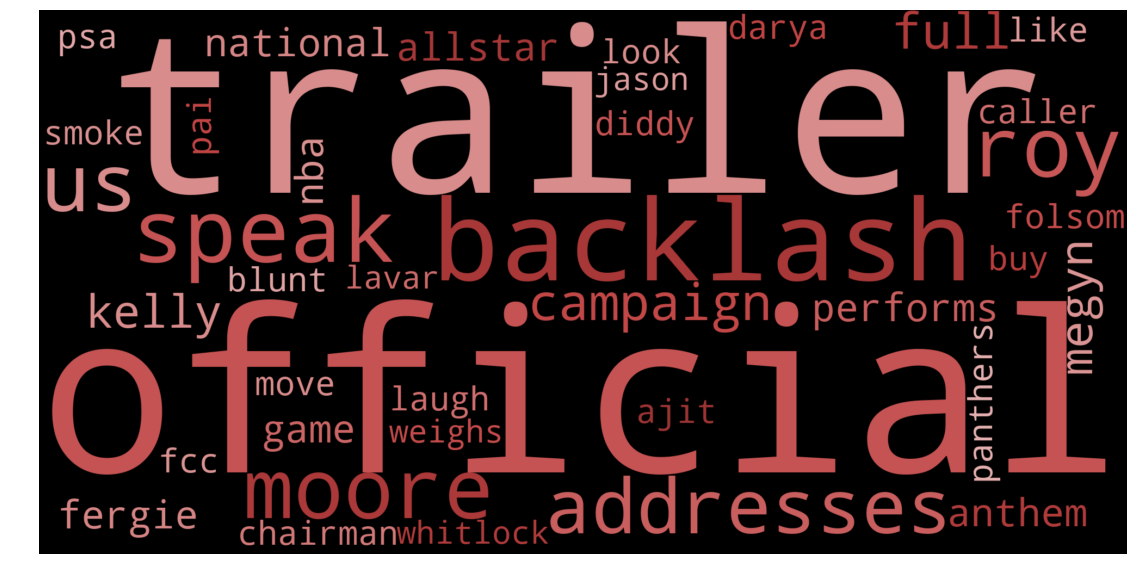

In [37]:
contro = trending_UK[trending_UK.like_dislike_ratio <= 1].title.values
gen_word_cloud(contro, 1, False)

#### 1.2 Overwegend positieve videos aan de hand van enkele woorden.

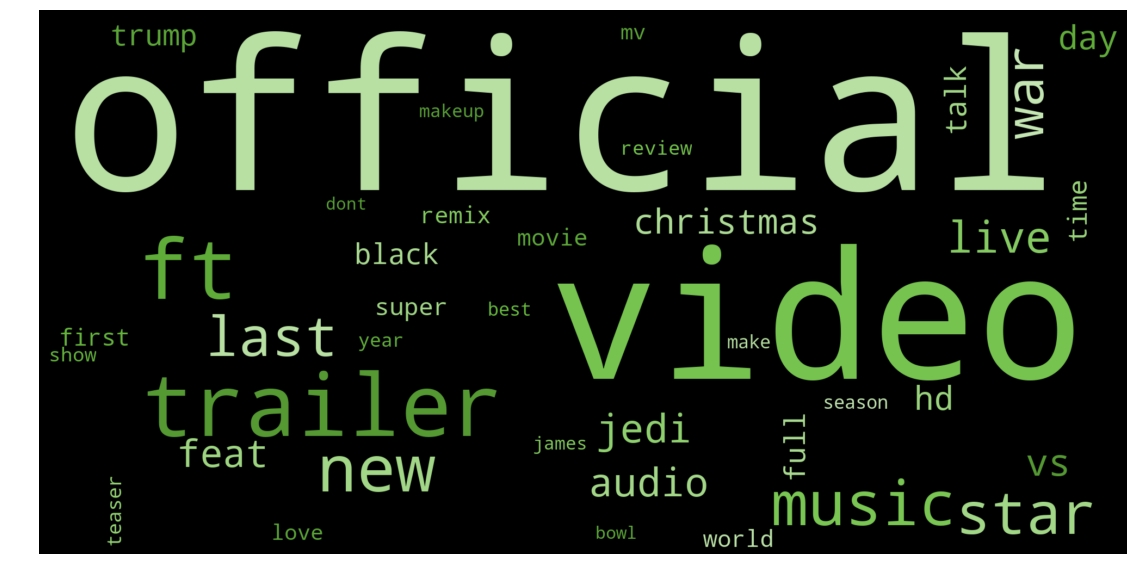

In [38]:
titles = trending_UK[trending_UK.like_dislike_ratio > 1].title.values
gen_word_cloud(titles, 2, False)

In [39]:
titles = stripTitlesCount(trending_UK.title.values, "UK")
titleslike = stripTitlesCount(trending_UK[trending_UK.like_dislike_ratio > 1].title.values, "UK")
titlesdislike = stripTitlesCount(trending_UK[trending_UK.like_dislike_ratio <= 1].title.values, "UK")

alles = sorted(titles.items(), key=operator.itemgetter(1), reverse=True)
like = sorted(titleslike.items(), key=operator.itemgetter(1), reverse=True)
dislike = sorted(titlesdislike.items(), key=operator.itemgetter(1), reverse=True)

print(alles[:20])
print(like[:20])
print(dislike[:20])

[('official', 3063), ('video', 2595), ('trailer', 1209), ('ft', 1196), ('music', 891), ('new', 842), ('last', 838), ('star', 779), ('wars', 695), ('live', 620), ('jedi', 617), ('audio', 580), ('vs', 565), ('feat', 562), ('christmas', 515), ('mv', 499), ('hd', 487), ('full', 451), ('black', 418), ('day', 414)]
[('official', 3005), ('video', 2570), ('ft', 1196), ('trailer', 1162), ('music', 891), ('new', 828), ('last', 822), ('star', 758), ('wars', 674), ('live', 620), ('jedi', 601), ('audio', 580), ('feat', 560), ('vs', 555), ('christmas', 506), ('mv', 499), ('hd', 483), ('full', 423), ('black', 418), ('x', 414)]
[('official', 51), ('trailer', 45), ('backlash', 43), ('roy', 33), ('moore', 33), ('us', 32), ('addresses', 30), ('campaign', 29), ('full', 28), ('megyn', 26), ('kelly', 26), ('fergie', 22), ('performs', 22), ('national', 22), ('anthem', 22), ('nba', 22), ('allstar', 22), ('game', 22), ('psa', 19), ('chairman', 19)]


## 2. Welke termen zijn het meest voorkomend in beschrijvingen en tags van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?


#### 2.1 Alle beschrijvingen aan de hand van enkele woorden met gefilterde stopwoorden

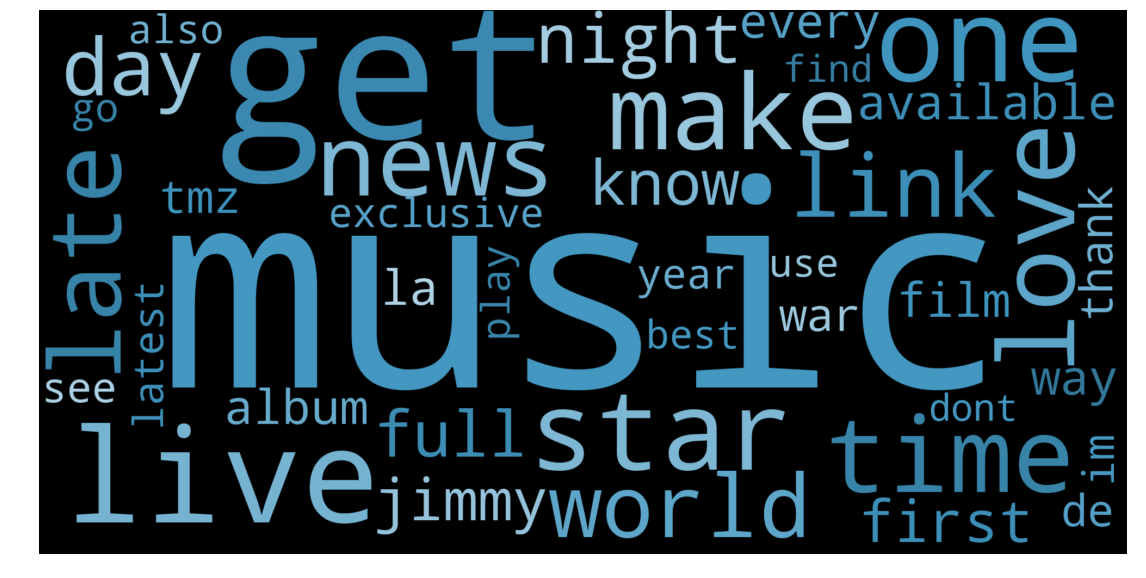

In [30]:
description = trending_UK.description.values
stopwoorden = ['subscribe', 'video', 'facebook', 'twitter', 'instagram', 'youtube', 'videos', 'channel', 'watch', 'like', 'new',
              'us', 'free', 'official', 'episode', 'website', 'show', 'movie']
gen_word_cloud(description, 3, False, stopwoorden + stopwords.words('english'))

#### 2.2 Alle beschrijvingen aan de hand van biagrams

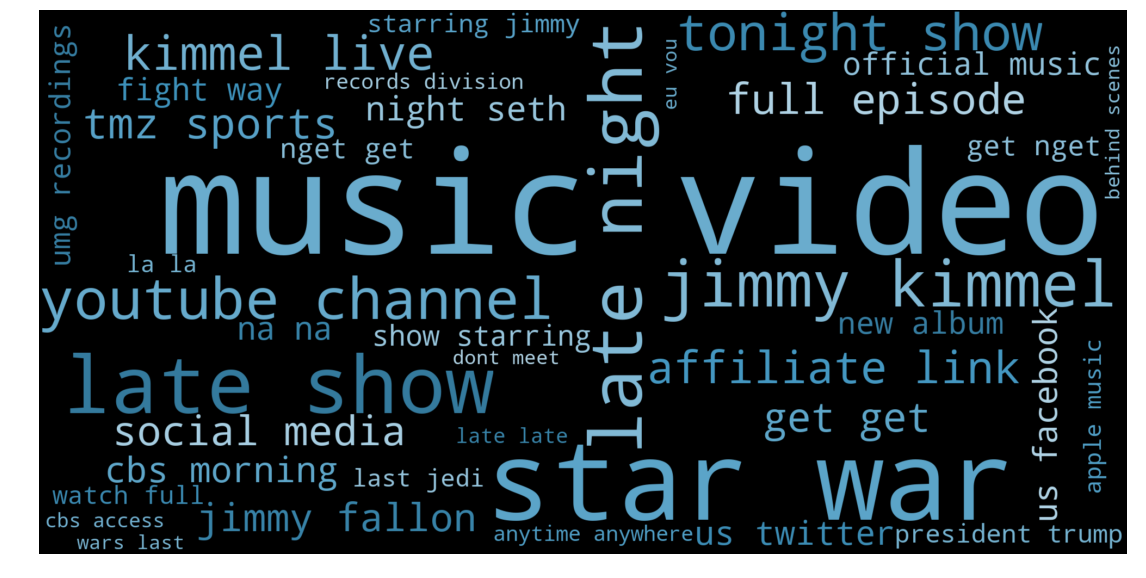

In [31]:
gen_word_cloud(description, 3, True)

#### 2.3 Alle tags aan de hand van biagrams met stopwoorden gefilterd

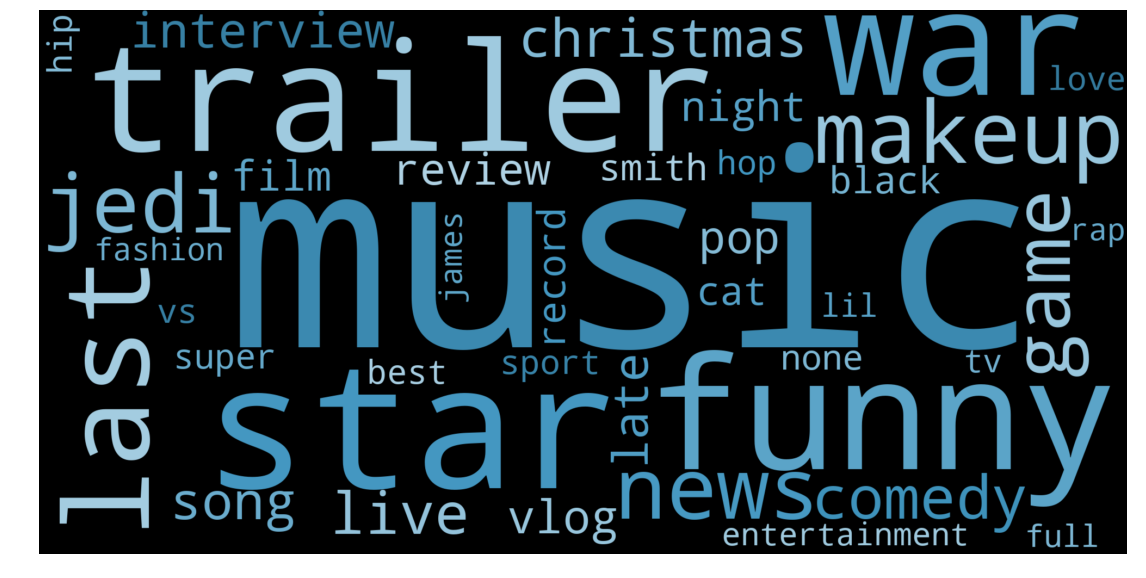

In [34]:
tags = [tag for row in trending_UK.tags.str.split('|') for tag in row]
gen_word_cloud(tags, 3, False, stopwoorden + stopwords.words('english'))

In [14]:
# Alle beschrijvingen bekijken, enkele woorden.
description = trending.description.values
#gen_word_cloud(description, 3, False)

In [15]:
descriptions = stripTitlesCount(description, "US")
descriptionlike = stripTitlesCount(trending[trending.like_view_ratio > 0.10].description.values, "US")
descriptiondislike = stripTitlesCount(trending[trending.dislike_view_ratio > 0.10].description.values, "US")

alles = sorted(descriptions.items(), key=operator.itemgetter(1), reverse=True)
like = sorted(descriptionlike.items(), key=operator.itemgetter(1), reverse=True)
dislike = sorted(descriptiondislike.items(), key=operator.itemgetter(1), reverse=True)

print(alles[:20])
print(like[:20])
print(dislike[:20])

[('_', 15177), ('video', 11710), ('us', 9325), ('new', 8104), ('videos', 7644), ('music', 6920), ('channel', 6661), ('twitter', 6385), ('get', 5979), ('news', 5851), ('facebook', 5694), ('subscribe', 5661), ('instagram', 5493), ('show', 5219), ('like', 5188), ('youtube', 5179), ('make', 4386), ('one', 4162), ('watch', 4024), ('►', 3893)]
[('video', 497), ('music', 378), ('new', 320), ('channel', 286), ('code', 214), ('»', 184), ('get', 178), ('use', 174), ('love', 163), ('book', 162), ('instagram', 143), ('know', 143), ('make', 136), ('us', 136), ('song', 134), ('want', 134), ('links', 132), ('album', 130), ('one', 126), ('like', 124)]
[('—', 8), ('internet', 7), ('subscribe', 7), ('news', 6), ('federal', 4), ('regulators', 4), ('vote', 4), ('allow', 4), ('providers', 4), ('speed', 4), ('service', 4), ('apps', 4), ('websites', 4), ('block', 4), ('slow', 4), ('others', 4), ('decision', 4), ('repealing', 4), ('landmark', 4), ('obamaera', 4)]


## 3. Is er een verband tussen de ratio van het aantal likes en het aantal views?


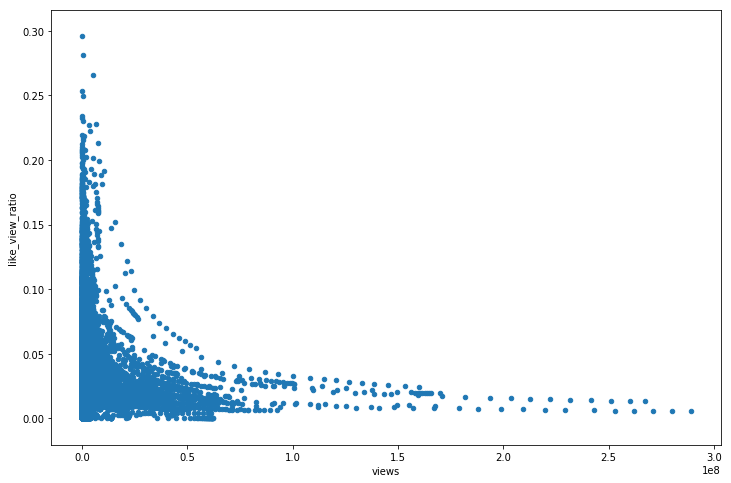

In [43]:
# Ratio likes ten opzichte van views.
trending_UK.sort_values(by='views').plot(x='views', y="like_view_ratio", figsize=(12,8), kind="scatter")

## 4. Is er een verband tussen de ratio van het aantal dislikes en het aantal views?


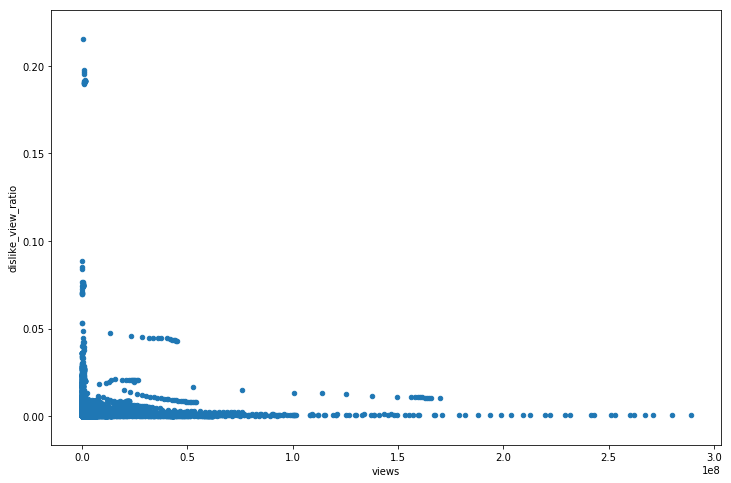

In [41]:
# Ratio dislikes ten opzichte van views.
trending_UK.sort_values(by='views').plot(x='views', y="dislike_view_ratio", figsize=(12,8), kind='scatter')

## 5. Zijn er verschillen in titels tussen US, GB en CA?

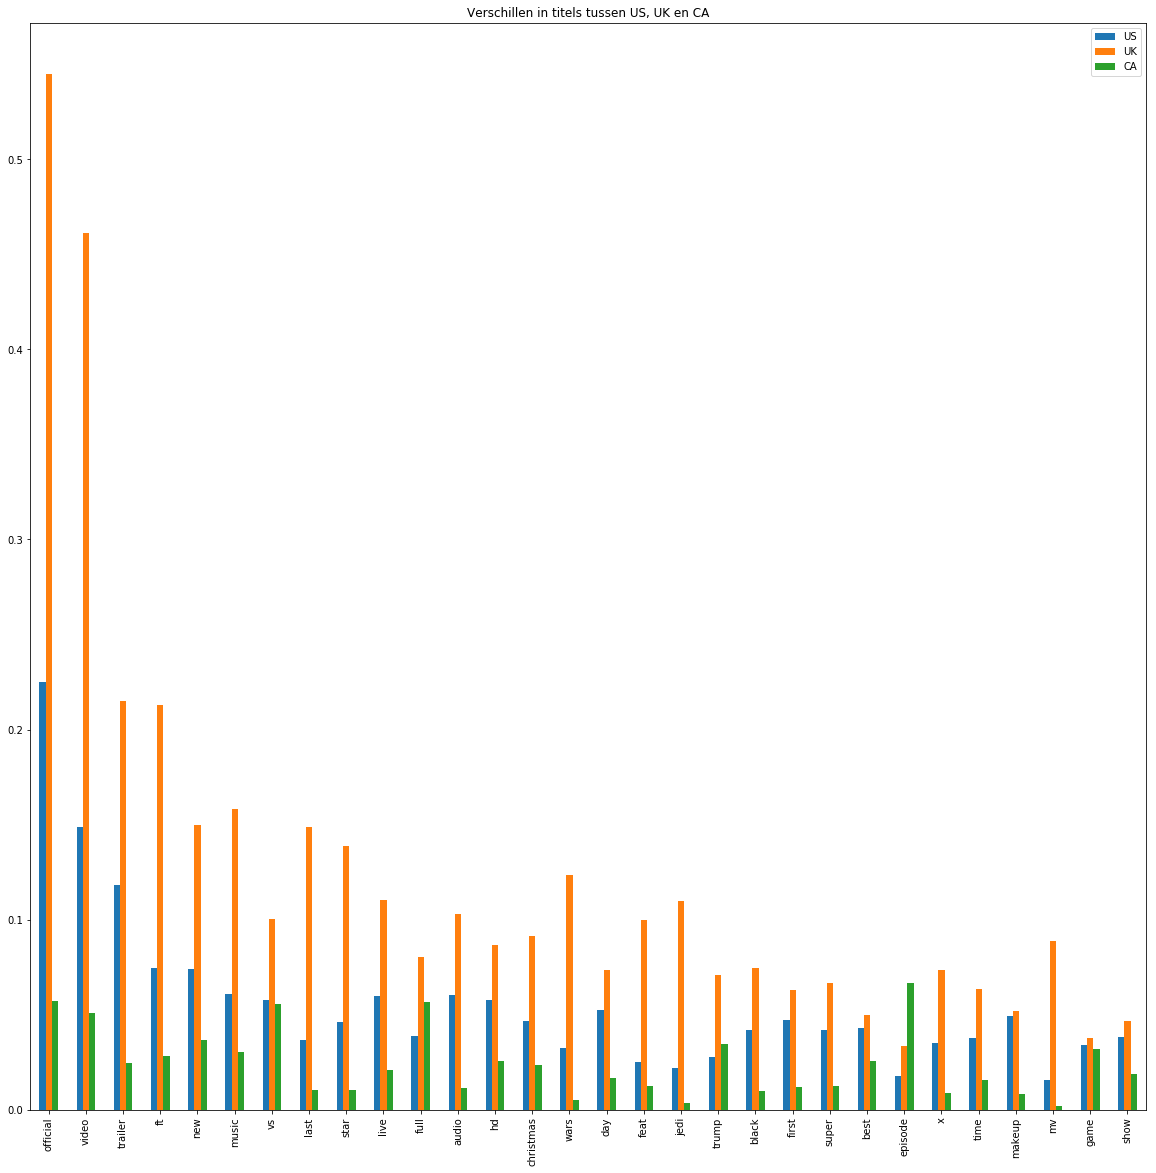

In [77]:

US=stripTitlesToDict(trending.title.values,"US")
CA=stripTitlesToDict(trending_CA.title.values,"CA")
UK=stripTitlesToDict(trending_UK.title.values,"UK")
US= US.join(CA).join(UK)
US["total"]=US.UK+US.US+US.CA
US.sort_values("total",ascending=False)[["US","UK","CA"]][:30].plot(kind="bar",figsize=(20,20),
                                                                    title='Verschillen in titels tussen US, UK en CA')

## 6. Wat is de gemiddelde toename aan views voor trending video's die meerdere dagen in de trending staan?


In [76]:
def find_increase(row,oldName,oldValue,streak):
    if row[1]==oldName:
        res= row[6]-oldValue
        streak+=1
        if res<0:
            return 0,streak
        else:
            return res,streak
    else:
        streak=1
        return row[6],streak

def findNewViews(trending):
    temp_list={}
    temp_day={}
    streak=1
    oldName = ""
    oldValue = 0
    for x in trending.sort_values(["title","views"]).iterrows():
        temp_list[x[0]],temp_day[x[0]]=find_increase(x[1],oldName,oldValue,streak)
        oldName=x[1][1]
        oldValue=x[1][6]
        streak = temp_day[x[0]]
    trending["increase_views"]=pd.DataFrame.from_dict(temp_list,orient="index")
    trending["days_in_trending"] = pd.DataFrame.from_dict(temp_day,orient="index")
    return trending
findNewViews(trending).sort_values(["title","views"])

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,...,description,category_name,like_view_ratio,dislike_view_ratio,like_dislike_ratio,timecode,publish_date,time_until_trending,increase_views,days_in_trending
10728,17.07.12,#184 Making a PCB using EasyEDA. // Review,MickMake,28,2017-12-02T14:05:07.000Z,"MickMake|""electronics""|""embedded""|""maker""|""diy...",3237,161,2,35,...,"If you're at the point of making your own PCB,...",Science & Technology,0.049737,0.000618,80.500000,15,17.3.12,111,3237,1
250,17.01.12,"#23 Feed The Homeless | One List, One Life","One List , One Life",22,2017-11-30T15:36:12.000Z,"homeless|""experiment""|""people""|""man""|""singing""...",32385,568,77,97,...,Learn more about us: https://mybestfriendslist...,People & Blogs,0.017539,0.002378,7.376623,16,17.31.11,1456,32385,1
267,17.02.12,"#23 Feed The Homeless | One List, One Life","One List , One Life",22,2017-11-30T15:36:12.000Z,"homeless|""experiment""|""people""|""man""|""singing""...",40644,667,85,106,...,Learn more about us: https://mybestfriendslist...,People & Blogs,0.016411,0.002091,7.847059,16,17.31.11,1432,8259,2
281,17.03.12,"#23 Feed The Homeless | One List, One Life","One List , One Life",22,2017-11-30T15:36:12.000Z,"homeless|""experiment""|""people""|""man""|""singing""...",41274,683,85,110,...,Learn more about us: https://mybestfriendslist...,People & Blogs,0.016548,0.002059,8.035294,16,17.31.11,1408,630,3
298,17.04.12,"#23 Feed The Homeless | One List, One Life","One List , One Life",22,2017-11-30T15:36:12.000Z,"homeless|""experiment""|""people""|""man""|""singing""...",41742,707,86,112,...,Learn more about us: https://mybestfriendslist...,People & Blogs,0.016937,0.002060,8.220930,16,17.31.11,1384,468,4
317,17.05.12,"#23 Feed The Homeless | One List, One Life","One List , One Life",22,2017-11-30T15:36:12.000Z,"homeless|""experiment""|""people""|""man""|""singing""...",42463,732,87,121,...,Learn more about us: https://mybestfriendslist...,People & Blogs,0.017239,0.002049,8.413793,16,17.31.11,1360,721,5
338,17.06.12,"#23 Feed The Homeless | One List, One Life","One List , One Life",22,2017-11-30T15:36:12.000Z,"homeless|""experiment""|""people""|""man""|""singing""...",43012,754,87,123,...,Learn more about us: https://mybestfriendslist...,People & Blogs,0.017530,0.002023,8.666667,16,17.31.11,1336,549,6
10990,18.04.01,#57: AM and SSB explained,Radio Physics and Electronics,28,2017-12-24T19:15:29.000Z,"AM|""SSB""|""amplitude modulation""|""single sideba...",3287,79,3,19,...,In this video we explore some of the simple ma...,Science & Technology,0.024034,0.000913,26.333333,20,17.25.12,8444,3287,1
11009,18.05.01,#57: AM and SSB explained,Radio Physics and Electronics,28,2017-12-24T19:15:29.000Z,"AM|""SSB""|""amplitude modulation""|""single sideba...",3466,83,3,19,...,In this video we explore some of the simple ma...,Science & Technology,0.023947,0.000866,27.666667,20,17.25.12,8420,179,2
11024,18.06.01,#57: AM and SSB explained,Radio Physics and Electronics,28,2017-12-24T19:15:29.000Z,"AM|""SSB""|""amplitude modulation""|""single sideba...",3570,84,3,21,...,In this video we explore some of the simple ma...,Science & Technology,0.023529,0.000840,28.000000,20,17.25.12,8396,104,3


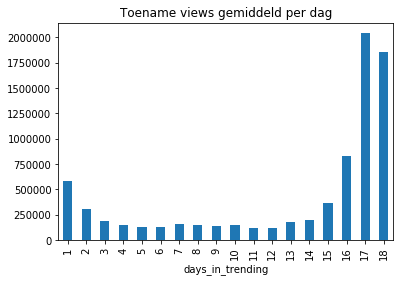

In [75]:
trending.groupby("days_in_trending").increase_views.mean().plot(x="days_in_trending",y="increase_views",kind="bar",
                                                               title='Toename views gemiddeld per dag')

## 7.  Wat zijn de meest voorkomende categorieën en hoe verschilt dat bij verschillende like/view ratio’s?

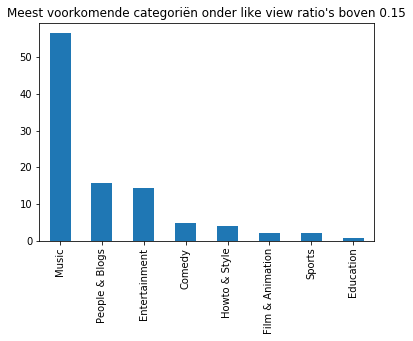

In [73]:
# Welke categorieën zijn sterk vertegenwoordigd bij de hoge ratio?
Representation=trending[trending.like_view_ratio > 0.15].category_name.value_counts()/len(trending[trending.like_view_ratio > 0.15])*100
Representation.plot(kind="bar", title="Meest voorkomende categoriën onder like view ratio's boven 0.15")


## Is er een verband tussen de publicatie tijd en het aantal views?

In [67]:
from datetime import date

def get_difference(publish_date, trending_date):
    """
    Calculates the difference in days between two given dates.
    """
    pub_strip = publish_date.split(".")
    tren_strip = trending_date.split(".")
    
    d1 = date(2000 + int(pub_strip[0]), int(pub_strip[2]), int(pub_strip[1]))
    d2 = date(2000 + int(tren_strip[0]), int(tren_strip[2]), int(tren_strip[1]))
    
    # return difference
    return abs((d2 - d1).days)

In [68]:
def add_difference(trending):
    """
    Helper function to add for every video the difference between, publish and trending date.
    """
    temp_dict={}
    for x in trending.index:
        try:
            temp_dict[x]= get_difference(trending.publish_date[x], trending.trending_date[x])
        except:
            temp_dict[x] = 0

        # Print progression percentage
        if x % 1000 == 0:
            print((x / 23370) * 100, '%')
    trending["difference"]=pd.DataFrame.from_dict(temp_dict,orient="index")
    return trending

In [69]:
# Remove duplicates
temp_trending = trending.drop_duplicates(subset='title')
# Calculate the difference for all videos
new_trending = add_difference(temp_trending)

0.0 %
47.0688917415 %
59.9058622165 %
77.0218228498 %
89.8587933248 %
94.1377834831 %


C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [70]:
new_trending

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,...,category_name,like_view_ratio,dislike_view_ratio,like_dislike_ratio,timecode,publish_date,time_until_trending,increase_views,days_in_trending,difference
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,...,People & Blogs,0.076869,0.003963,19.395482,18,17.14.11,18,748374,1,0
1,17.14.11,Me-O Cats Commercial,Nobrand,22,2017-04-21T06:47:32.000Z,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,...,People & Blogs,0.025120,0.001859,13.510870,7,17.22.04,5239,98966,1,206
2,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,22,2017-11-11T15:00:03.000Z,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,...,People & Blogs,0.013864,0.005519,2.511851,15,17.12.11,63,321053,1,2
3,17.14.11,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,22,2017-11-11T18:08:04.000Z,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,456,...,People & Blogs,0.036790,0.001101,33.410138,19,17.12.11,67,197062,1,2
4,17.14.11,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,22,2017-11-11T01:19:33.000Z,wearing online dollar store makeup for a week|...,2744430,115426,1110,6541,...,People & Blogs,0.042058,0.000404,103.987387,2,17.12.11,50,2744430,1,2
5,17.14.11,Mark Ruffalo Reads Hilarious Thirst Tweets,BuzzFeed Celeb,22,2017-11-11T00:30:16.000Z,"BuzzFeed|""buzzfeed celeb""|""Mark Ruffalo""|""Thor...",177707,6271,88,275,...,People & Blogs,0.035288,0.000495,71.261364,1,17.12.11,49,177707,1,2
6,17.14.11,Idiot's Guide to Japanese Squat Toilets,Rachel and Jun,22,2017-11-09T11:24:14.000Z,"Japan|""Japanese""|""yt:cc=on""|""idiot's""|""guide""|...",1098897,43875,1326,4702,...,People & Blogs,0.039926,0.001207,33.088235,12,17.10.11,108,1098897,1,4
7,17.14.11,"Russian Bots and Trolls | November 8, 2017 Act...",Full Frontal with Samantha Bee,22,2017-11-09T07:00:01.000Z,"Full Frontal with Samantha Bee|""Full Frontal""|...",362009,5505,2356,1264,...,People & Blogs,0.015207,0.006508,2.336587,7,17.10.11,103,362009,1,4
8,17.14.11,The Ultimate Red Lip Look | Nicole Guerriero,Nicole Guerriero,22,2017-11-10T00:24:29.000Z,"nicole guerriero|""arriba liqud lipstick""|""colo...",294387,15247,385,976,...,People & Blogs,0.051792,0.001308,39.602597,1,17.11.11,73,294387,1,3
9,17.14.11,Could Anastasia Become A Disney Princess?,SuperCarlinBrothers,22,2017-11-09T23:27:18.000Z,"SuperCarlinBrothers|""disney""|""fox""|""disney pri...",188003,9091,135,2814,...,People & Blogs,0.048356,0.000718,67.340741,0,17.10.11,96,188003,1,4


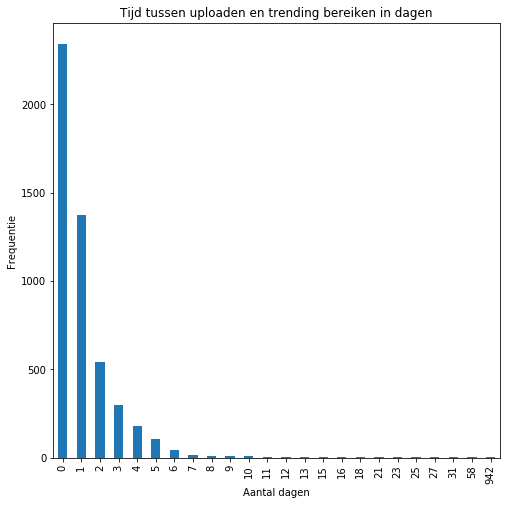

In [71]:
# Count values, and select the values who occur more then once. Sort from 0 days to 20 days.
new_trending.difference.value_counts().sort_index()[new_trending.difference.value_counts() > 1].plot(kind='bar', figsize=(8,8),
                                            title='Tijd tussen uploaden en trending bereiken in dagen')
# Add X and Y label
plt.xlabel('Aantal dagen')
plt.ylabel('Frequentie')
plt.show()